# Exploratory Spatio-Temporal Data Analysis
# Data Inspection and Descriptive Statistics - Summary Statistics

## Load data

In [42]:
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [43]:
import xarray as xr
import glob

def preprocess_dataset(ds: xr.Dataset) -> xr.Dataset:
    """
    Preprocess the dataset to ensure the `valid_time` coordinate is in `datetime64[ns]` format.

    Args:
        ds (xr.Dataset): Input dataset.

    Returns:
        xr.Dataset: Preprocessed dataset with `valid_time` converted to datetime.
    """
    if "valid_time" in ds.coords:
        ds["valid_time"] = ds["valid_time"].dt.floor("D")  # Truncate to date only
    return ds

# Define the directory containing your NetCDF files
data_dir = 'drought-forecasting/modeling-pipeline/data/01_raw/unzipped_files/ERA5_monthly_averaged_data_on_single_levels/'

# Create a sorted list of file paths
file_list = sorted(glob.glob(data_dir + '*.nc'))

# Open multiple files as a single dataset with preprocessing applied
ds = xr.open_mfdataset(
    file_list, 
    combine='by_coords', 
    preprocess=preprocess_dataset
)


In [44]:
ds

<xarray.Dataset> Size: 55GB
Dimensions:     (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...          ...
    si10        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

# NA Values 

In [45]:
# import xarray as xr

# # Check for missing values in each variable without compute
# missing_values = {var: ds[var].isnull().any().values for var in ds.data_vars}

# # Display the results
# for var, has_missing in missing_values.items():
#     print(f"Variable '{var}': {'Has missing values' if has_missing else 'No missing values'}")


# Fill NA values

In [46]:
import xarray as xr
from typing import List, Union

def fillna_in_variables(
    ds: xr.Dataset,
    variables: List[str],
    fill_value: Union[int, float]
) -> xr.Dataset:
    """
    Fills NaN values in specified variables of an xarray.Dataset with a provided value.

    Args:
        ds (xr.Dataset): The input dataset containing the data variables.
        variables (List[str]): A list of variable names in the dataset for which to fill NaN values.
        fill_value (Union[int, float]): The value to fill NaN values with (e.g., 0).

    Returns:
        xr.Dataset: A new dataset with NaN values filled in the specified variables.
    
    Example:
        ds = fillna_in_variables(ds, ["sst", "t2m"], fill_value=0)
    """
    # Check if each variable exists in the dataset
    for var in variables:
        if var not in ds:
            raise ValueError(f"Variable '{var}' not found in the dataset.")
    
    # Fill NaN values for the specified variables
    filled_ds = ds.copy()
    for var in variables:
        filled_ds[var] = filled_ds[var].fillna(fill_value)
    
    return filled_ds

In [47]:
ds = fillna_in_variables(ds, ["sst"], fill_value=0)

In [48]:
# import xarray as xr

# # Check for missing values in each variable without compute
# missing_values = {var: ds[var].isnull().any().values for var in ds.data_vars}

# # Display the results
# for var, has_missing in missing_values.items():
#     print(f"Variable '{var}': {'Has missing values' if has_missing else 'No missing values'}")


## Data Preprocessing and Feature Engineering 

In [49]:
import numpy as np
import xarray as xr

def interpolate_to_target_grid(ds, target_lat, target_lon, method="linear"):
    """
    Interpolates an xarray Dataset to a specified target latitude and longitude grid.
    
    Parameters:
        ds (xr.Dataset): The input dataset to be interpolated.
        target_lat (array-like): Target latitude values (e.g., np.arange(-90, 90, 1)).
        target_lon (array-like): Target longitude values (e.g., np.arange(0, 360, 1)).
        method (str): Interpolation method. Defaults to 'linear'.
                      Options include 'linear', 'nearest', etc.
    
    Returns:
        xr.Dataset: The interpolated dataset on the specified target grid.
    """
    # Step 1: Ensure latitude is in ascending order
    if ds.latitude[0] > ds.latitude[-1]:
        ds = ds.sortby("latitude")
    
    # Step 2: Perform interpolation
    interpolated_ds = ds.interp(latitude=target_lat, longitude=target_lon, method=method)
    
    return interpolated_ds

# Example usage
target_lat = np.arange(-90, 90, 1)   # 1° resolution latitude
target_lon = np.arange(0, 360, 1)   # 1° resolution longitude
method = "linear"

# ds = interpolate_to_target_grid(ds, target_lat, target_lon, method)

In [50]:
# Save the original attributes
original_attrs = ds['tp'].attrs

# Perform the conversion
ds['tp'] = ds['tp'] * 1000

# Restore the original attributes and update the units
ds['tp'].attrs = original_attrs
ds['tp'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

In [51]:
# Save the original attributes
original_attrs = ds['e'].attrs

# Perform the conversion
ds['e'] = ds['e'] * 1000

# Restore the original attributes and update the units
ds['e'].attrs = original_attrs
ds['e'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

In [52]:
# Save the original attributes
original_attrs = ds['pev'].attrs

# Perform the conversion
ds['pev'] = ds['pev'] * 1000

# Restore the original attributes and update the units
ds['pev'].attrs = original_attrs
ds['pev'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

In [53]:
# Update swvl1: Set to 1 wherever lsm indicates water 
ds['swvl1'] = ds['swvl1'].where(ds['lsm'] != 0, other=1)

# Update pev: Set to 0 wherever lsm indicates water 
ds['pev'] = ds['pev'].where(ds['lsm'] != 0, other=0)

# Additional variables for deeper exploration

## Caluclate percent of mean 

In [54]:
import xarray as xr
import numpy as np
from typing import Tuple

def calculate_percent_of_normal(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Generalized function to calculate Percent of Normal for a given variable.

    Args:
        ds (xr.Dataset): Input dataset containing the variable.
        variable (str): Variable name for which Percent of Normal is to be calculated.
        date_range (Tuple[str, str]): Climatology period as (start_date, end_date).

    Returns:
        xr.Dataset: Dataset with Percent of Normal added as a new variable.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))

    # Step 2: Extract the variable and calculate monthly climatology mean
    data_clim_period = ds_clim_period[variable]
    climatology_mean = data_clim_period.groupby('valid_time.month').mean('valid_time')

    # Replace zeros and NaNs in climatology_mean with a small number
    climatology_mean = climatology_mean.where(climatology_mean > 0, other=1e-10).fillna(1e-10)

    # Step 3: Calculate Percent of Normal for all valid_time in the original dataset
    data_full = ds[variable]
    percent_of_normal = xr.apply_ufunc(
        lambda x, m: (x / m) * 100,
        data_full.groupby('valid_time.month'),
        climatology_mean,
        dask="allowed"
    )
    
    # Step 4: Add Percent of Normal to the original dataset
    ds_result = ds.copy()
    ds_result[f"{variable}_percent_of_normal"] = percent_of_normal

    return ds_result


In [55]:
date_range = ("1991-01-01", "2020-12-31")

# Assuming `ds` is your dataset
ds = calculate_percent_of_normal(ds, variable='tp', date_range=date_range)
ds = calculate_percent_of_normal(ds, variable='t2m', date_range=date_range)
ds = calculate_percent_of_normal(ds, variable='swvl1', date_range=date_range)

## Caluclate standardized monthly anomalies based on std 

In [56]:
import xarray as xr
import numpy as np
from typing import Tuple

def calculate_standardized_anomalies(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Calculate standardized monthly anomalies for a specific variable,
    handling cases with zero standard deviation or NaNs.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))
    
    # Step 2: Extract the variable and calculate monthly climatology (mean and std)
    data_clim_period = ds_clim_period[variable]
    climatology_mean = data_clim_period.groupby('valid_time.month').mean('valid_time')
    climatology_std = data_clim_period.groupby('valid_time.month').std('valid_time')

    # Replace zero standard deviation with a small number
    climatology_std = climatology_std.where(climatology_std > 0, other=1e-10)

    # Step 3: Calculate standardized anomalies for all valid_time in the original dataset
    data_full = ds[variable]
    standardized_anomalies = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        data_full.groupby('valid_time.month'),
        climatology_mean,
        climatology_std,
        dask="allowed"
    )

    # Step 4: Add standardized anomalies to the original dataset
    ds_standardized_anomalies = ds.copy()
    ds_standardized_anomalies[f"{variable}_std_anomaly"] = standardized_anomalies

    return ds_standardized_anomalies

In [57]:
date_range = ("1991-01-01", "2020-12-31")

ds = calculate_standardized_anomalies(ds, variable='tp', date_range=date_range)
ds = calculate_standardized_anomalies(ds, variable='t2m', date_range=date_range)
ds = calculate_standardized_anomalies(ds, variable='pev', date_range=date_range)
ds = calculate_standardized_anomalies(ds, variable='swvl1', date_range=date_range)

create land variables 

In [58]:
import xarray as xr

def create_land_variable(ds: xr.Dataset, variable: str, lsm_var: str = "lsm") -> xr.Dataset:
    """
    Create a land-only version of a specified variable using a land-sea mask (lsm).

    Args:
        ds (xr.Dataset): The input xarray dataset containing the variables.
        variable (str): The name of the variable to create the land-only version for.
        lsm_var (str): The name of the land-sea mask variable. Default is 'lsm'.

    Returns:
        xr.Dataset: A new dataset with the land-only version of the specified variable.

    Raises:
        ValueError: If the specified variable or land-sea mask is not present in the dataset.
    """
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    if lsm_var not in ds:
        raise ValueError(f"Land-sea mask variable '{lsm_var}' not found in the dataset.")

    # Ensure the land-sea mask is binary-like
    lsm = ds[lsm_var].where(ds[lsm_var] >= 0, other=0)

    # Mask the variable using the land-sea mask (threshold for land > 0.5)
    land_variable = ds[variable].where(lsm > 0.5)

    # Add the new variable to the dataset with a descriptive name
    land_var_name = f"{variable}_land_only"
    ds[land_var_name] = land_variable

    # Add metadata to the new variable
    ds[land_var_name].attrs.update({
        "description": f"Land-only version of {variable} based on {lsm_var}",
        "units": ds[variable].attrs.get("units", "unknown"),
        "land_only": True
    })

    return ds


In [59]:
# Example usage:
ds = create_land_variable(ds, "tp_std_anomaly")
ds = create_land_variable(ds, "t2m_std_anomaly")

ds = create_land_variable(ds, "tp_percent_of_normal")
ds = create_land_variable(ds, "t2m_percent_of_normal")

Mask downloaded from [Global Drought Crops Monitoring](https://global-drought-crops.csic.es/#map_name=all_spei_3#map_position=2205)

In [60]:
import xarray as xr
import os
import glob

# Define the preprocess function
def preprocess(file_path):
    """
    Preprocess a single dataset:
    - Load the dataset.
    - Extract the crop name from the file path.
    - Keep only the 'croparea' variable.
    - Rename 'croparea' to include the crop name.
    - Remove attributes to avoid conflicts.

    Args:
        file_path (str): Path to the NetCDF file.

    Returns:
        xarray.Dataset: Preprocessed dataset.
    """
    # Load the dataset
    ds = xr.open_dataset(file_path, chunks="auto")
    
    # Extract crop name from filename
    file_name = os.path.basename(file_path)
    crop_name = file_name.split("_")[-1].split(".")[0]  # Extracts 'carrot'

    # Keep only 'croparea' and rename it
    ds = ds[['croparea']].rename_vars({'croparea': f'{crop_name}_croparea'})

    # Remove conflicting attributes
    ds.attrs = {}
    return ds

# Define the directory containing your NetCDF files
data_dir = '/teamspace/studios/this_studio/drought-forecasting/modeling-pipeline/data/01_raw/unzipped_files/CROPGRIDS/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_NC_maps/'

# Create a sorted list of file paths
file_list = sorted(glob.glob(data_dir + '*.nc'))

# Exclude specific file
excluded_file = 'Countries_2018.nc'
file_list = [file for file in file_list if not file.endswith(excluded_file)]

# Preprocess each file and combine them
datasets = [preprocess(file_path) for file_path in file_list]
crop_ds = xr.combine_by_coords(datasets, combine_attrs="override")

# Apply mask: Set values below 100 to 0, and values equal to or above 100 to 1
crop_ds = crop_ds.map(lambda da: xr.where(da >= 1, 1, 0))

# Step 1: Adjust longitude for crop_ds
crop_ds = crop_ds.assign_coords(lon=((crop_ds.lon + 360) % 360)).sortby('lon')

In [61]:
crop_ds

<xarray.Dataset> Size: 36GB
Dimensions:                  (lat: 3600, lon: 7200)
Coordinates:
  * lat                      (lat) float32 14kB -89.97 -89.93 ... 89.93 89.97
  * lon                      (lon) float32 29kB 0.02499 0.07501 ... 359.9 360.0
Data variables: (12/173)
    abaca_croparea           (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    agave_croparea           (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    alfalfa_croparea         (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    almond_croparea          (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    aniseetc_croparea        (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    apple_croparea           (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    ...                       ...
    vetch_croparea           (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    walnut_croparea          (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    watermelon_croparea      (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    wheat_croparea           (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    yam_croparea             (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>
    yautia_croparea          (lat, lon) int64 207MB dask.array<chunksize=(3600, 7200), meta=np.ndarray>

In [62]:
import xarray as xr

def mask_with_crop_area(ds: xr.Dataset, crop_ds: xr.Dataset, variable: str, crop: str) -> xr.Dataset:
    """
    Interpolates `crop_ds` to match `ds` using Dask, then masks a variable in `ds` with a crop area from `crop_ds`.
    Creates a new variable in `ds` with the masked values.

    Args:
        ds (xr.Dataset): Dataset containing the variable to mask.
        crop_ds (xr.Dataset): Dataset containing crop area variables.
        variable (str): Name of the variable in `ds` to mask.
        crop (str): Specific crop variable to use for masking (e.g., 'cotton_croparea').

    Returns:
        xr.Dataset: Dataset with a new variable containing the masked values.

    Raises:
        ValueError: If the specified variable or crop is not found in the datasets.
    """
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset `ds`.")

    # Unify chunks for consistent Dask operations
    ds = ds.unify_chunks()
    crop_ds = crop_ds.unify_chunks()

    # Check if the specific crop is in the crop dataset
    if crop not in crop_ds:
        raise ValueError(f"Crop variable '{crop}' not found in the dataset `crop_ds`.")

    # Use the specific crop area as the mask
    mask = crop_ds[crop]

    # Interpolate crop mask to match `ds` spatial resolution using Dask
    interpolated_mask = mask.interp(
        lat=ds.latitude, lon=ds.longitude, method="nearest"
    )

    # Mask the variable
    masked_variable = ds[variable].where(interpolated_mask > 0)

    # Add the masked variable as a new variable in the dataset
    masked_variable_name = f"{variable}_{crop}"
    ds[masked_variable_name] = masked_variable

    return ds


In [63]:
# Apply mask for specific crop
ds = mask_with_crop_area(ds, crop_ds, "tp_percent_of_normal", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "tp_std_anomaly", crop="barley_croparea")

ds = mask_with_crop_area(ds, crop_ds, "t2m", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "t2m_percent_of_normal", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "t2m_std_anomaly", crop="barley_croparea")

ds = mask_with_crop_area(ds, crop_ds, "pev", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "pev_std_anomaly", crop="barley_croparea")

ds = mask_with_crop_area(ds, crop_ds, "swvl1", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "swvl1_percent_of_normal", crop="barley_croparea")
ds = mask_with_crop_area(ds, crop_ds, "swvl1_std_anomaly", crop="barley_croparea")

In [64]:
ds

<xarray.Dataset> Size: 103GB
Dimensions:                                  (valid_time: 551, latitude: 721,
                                              longitude: 1440)
Coordinates:
    number                                   int64 8B 0
  * valid_time                               (valid_time) datetime64[ns] 4kB ...
  * latitude                                 (latitude) float64 6kB 90.0 ... ...
  * longitude                                (longitude) float64 12kB 0.0 ......
    expver                                   (valid_time) <U4 9kB dask.array<chunksize=(45,), meta=np.ndarray>
    month                                    (valid_time) int64 4kB 1 2 ... 11
    lat                                      (latitude) float64 6kB 90.0 ... ...
    lon                                      (longitude) float64 12kB 0.0 ......
Data variables: (12/45)
    cl                                       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    cvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    tvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    asn                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    sst                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    slt                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    ...                                       ...
    t2m_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_barley_croparea                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_barley_croparea                    (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_percent_of_normal_barley_croparea  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_std_anomaly_barley_croparea        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## Data Inspection

#### Whole range of dates

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional

import dask.array as da

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    time_dim: str = 'valid_time',
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    plot_type: str = 'scatter_geo',
    downsample_factor: Optional[int] = 1,
    projection: str = 'natural earth',
    color_scale: Optional[list] = None,
    custom_boundaries: Optional[list] = None,
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
    custom_colorbar_title: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    **kwargs
) -> go.Figure:
    """
    Modified function to visualize variables in xarray.Dataset with dask support.
    """
    grib_name = dataset[variable].attrs.get("GRIB_name", variable)
    grib_units = dataset[variable].attrs.get("GRIB_units", "")
    if not title:
        title = f"{grib_name}"
        if start_date or end_date:
            title += f" ({start_date or ''} to {end_date or ''})"
    colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

    da = dataset[variable]

    for dim in [time_dim, lat_dim, lon_dim]:
        if dim not in da.dims:
            raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

    if start_date or end_date:
        if start_date:
            da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
        if end_date:
            da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

    if downsample_factor > 1:
        da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

    if custom_boundaries and color_scale:
        boundaries = custom_boundaries
        cmap = mcolors.ListedColormap(color_scale)
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)
        color_min, color_max = boundaries[0], boundaries[-1]
    else:
        # Approximate min and max with dask
        color_min = vmin if vmin is not None else float(da.min().compute())
        color_max = vmax if vmax is not None else float(da.max().compute())

    if plot_type == 'scatter_geo':
        df = da.to_dataframe().reset_index().dropna(subset=[variable])

        fig = px.scatter_geo(
            df,
            lat=lat_dim,
            lon=lon_dim,
            color=variable,
            animation_frame=animation_frame,
            projection=projection,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            labels={variable: grib_name},
            hover_data={variable: f":.{hover_precision}f"},
            range_color=(color_min, color_max),
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )

    elif plot_type == 'imshow':
        z = da.mean(dim=time_dim).values
        if isinstance(z, da.Array):  # Ensure dask array is computed for imshow
            z = z.compute()
        if da[lat_dim][0] > da[lat_dim][-1]:
            z = z[::-1, :]

        fig = px.imshow(
            z,
            labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
            x=da[lon_dim].values,
            y=da[lat_dim].values,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            range_color=(color_min, color_max),
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    else:
        raise ValueError(f"Plot type '{plot_type}' is not supported.")

    return fig


In [66]:
# variable = 'cl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Blues'
# )
# fig.show()

In [67]:
# variable = 'cvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'YlGn'
# )
# fig.show()

In [68]:
# variable = 'tvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [69]:
# variable = 'asn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'ice'
# )
# fig.show()

In [70]:
# variable = 'sst'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Plasma'
# )
# fig.show()

In [71]:
# variable = 'slt'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [72]:
# variable = 'lai_hv'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'tempo'
# )
# fig.show()

In [73]:
# variable = 'tclw'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Blues'
# )
# fig.show()

In [74]:
# variable = 'tciw'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Greys_r'
# )
# fig.show()

In [75]:
# variable = 'z'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [76]:
# variable = 'sp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Plasma'
# )
# fig.show()

In [77]:
# variable = 'msl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdYlBu_r'
# )
# fig.show()

In [78]:
# variable = 'tcc'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'BuPu'
# )
# fig.show()

In [79]:
# variable = 'u10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Bluered'
# )
# fig.show()

In [80]:
# variable = 'v10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Bluered'
# )
# fig.show()

In [81]:
# variable = 't2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [82]:
# variable = 'd2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [83]:
# variable = 'si10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [84]:
# variable = 'e'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r'
# )
# fig.show()

In [85]:
# variable = 'ro'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'dense'
# )
# fig.show()

In [86]:
# variable = 'tp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'viridis',
#     vmin=0,
#     vmax=50
# )
# fig.show()

In [87]:
# variable = 'pev'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r',
#     vmin=-10,
#     vmax=-4
# )
# fig.show()

In [88]:
# # Define custom boundaries and colors
# custom_boundaries = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# custom_colors = ['darkred', 'red', 'orange', 'yellow', 'green', 'green', 'lightblue', 'blue', 'darkblue']

# # Call the function with the updated arguments
# variable = 'swvl1'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale=custom_colors,
#     custom_boundaries=custom_boundaries,
#     title='Volumetric Soil Water Layer 1'
# )

# fig.show()

In [89]:
ds

<xarray.Dataset> Size: 103GB
Dimensions:                                  (valid_time: 551, latitude: 721,
                                              longitude: 1440)
Coordinates:
    number                                   int64 8B 0
  * valid_time                               (valid_time) datetime64[ns] 4kB ...
  * latitude                                 (latitude) float64 6kB 90.0 ... ...
  * longitude                                (longitude) float64 12kB 0.0 ......
    expver                                   (valid_time) <U4 9kB dask.array<chunksize=(45,), meta=np.ndarray>
    month                                    (valid_time) int64 4kB 1 2 ... 11
    lat                                      (latitude) float64 6kB 90.0 ... ...
    lon                                      (longitude) float64 12kB 0.0 ......
Data variables: (12/45)
    cl                                       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    cvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    tvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    asn                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    sst                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    slt                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    ...                                       ...
    t2m_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_barley_croparea                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_barley_croparea                    (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_percent_of_normal_barley_croparea  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_std_anomaly_barley_croparea        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [90]:
# variable = 'tp_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [91]:
# variable = 't2m_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [92]:
# variable = 'swvl1_percent_of_normal'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [93]:
# variable = 'tp_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [94]:
# variable = 't2m_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [95]:
# variable = 'pev_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [96]:
# variable = 'swvl1_std_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [97]:
# variable = 'tp_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [98]:
# variable = 't2m_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [99]:
# variable = 'pev_std_anomaly_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [100]:
# variable = 'tp_percent_of_normal_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [101]:
# variable = 't2m_percent_of_normal_land_only'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [102]:
# variable = 'tp_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=0,
#     vmax=200
# )
# fig.show()

In [103]:
# variable = 'tp_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [104]:
# variable = 't2m_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-20 + 273.15,
#     vmax=25 + 273.15,
# )
# fig.show()

In [105]:
# variable = 't2m_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=97.5,
#     vmax=102.5
# )
# fig.show()

In [106]:
# variable = 't2m_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [107]:
# variable = 'pev_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Reds_r',
#     vmin=-10,
#     vmax=-4
# )
# fig.show()

In [108]:
# variable = 'pev_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

In [109]:
# # Define custom boundaries and colors
# custom_boundaries = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# custom_colors = ['darkred', 'red', 'orange', 'yellow', 'green', 'green', 'lightblue', 'blue', 'darkblue']

# # Call the function with the updated arguments
# variable = 'swvl1_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale=custom_colors,
#     custom_boundaries=custom_boundaries,
#     title='Volumetric Soil Water Layer 1'
# )

# fig.show()

In [110]:
# variable = 'swvl1_percent_of_normal_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu_r',
#     vmin=50,
#     vmax=150
# )
# fig.show()

In [111]:
# variable = 'swvl1_std_anomaly_barley_croparea'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'RdBu',
#     vmin=-2,
#     vmax=2
# )
# fig.show()

### Missing values

In [112]:
import xarray as xr

def check_missing_percentage(dataset: xr.Dataset) -> dict:
    """
    Calculate the percentage of missing values for each variable in the xarray.Dataset.

    Args:
        dataset (xr.Dataset): The input dataset.

    Returns:
        dict: A dictionary with variable names as keys and their respective missing percentage as values.
    """
    missing_percentages = {}
    for var in dataset.data_vars:
        data = dataset[var]
        # Calculate the number of missing values and total elements
        missing_count = data.isnull().sum().item()
        total_count = data.size
        # Calculate the missing percentage
        missing_percentage = (missing_count / total_count) * 100
        missing_percentages[var] = missing_percentage
    
    return missing_percentages


In [113]:
# # Example usage
# missing_perc = check_missing_percentage(ds)

In [114]:
# missing_perc

In [115]:
# # Example usage
# missing_perc_after_filling = check_missing_percentage(ds)

In [116]:
# missing_perc_after_filling

### Variables Distributions

In [117]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional

def plot_variable_distributions(ds: xr.Dataset, variables: Optional[List[str]] = None) -> None:
    """
    Plot the distribution of specified variables in the xarray Dataset.
    If no variables are specified, plot the distributions of all variables.

    Args:
        ds (xr.Dataset): The xarray dataset containing variables to visualize.
        variables (List[str], optional): List of variable names to plot.
                                         If None, plots all variables.
    """
    # Determine variables to plot
    variables_to_plot = variables if variables else list(ds.data_vars)
    
    for var in variables_to_plot:
        if var not in ds:
            print(f"Variable '{var}' not found in the dataset. Skipping.")
            continue
        
        data = ds[var].values.flatten()  # Flatten the data for distribution plot
        
        # Remove NaN values to avoid plotting issues
        data = data[~np.isnan(data)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=50, alpha=0.7, color='violet')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

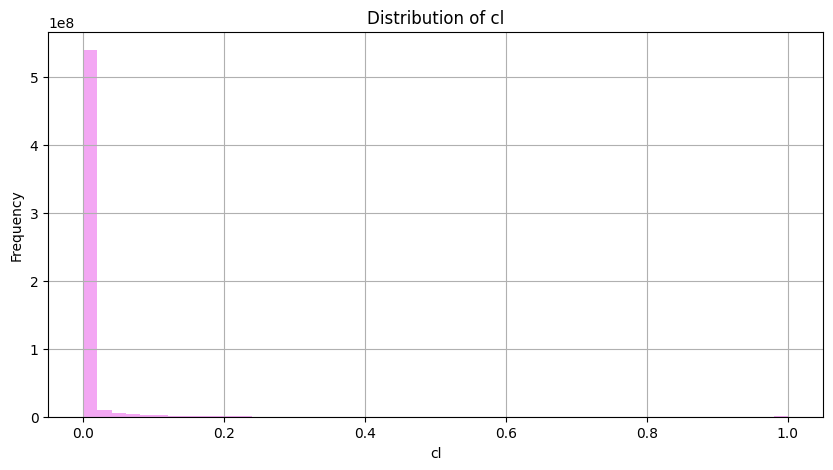

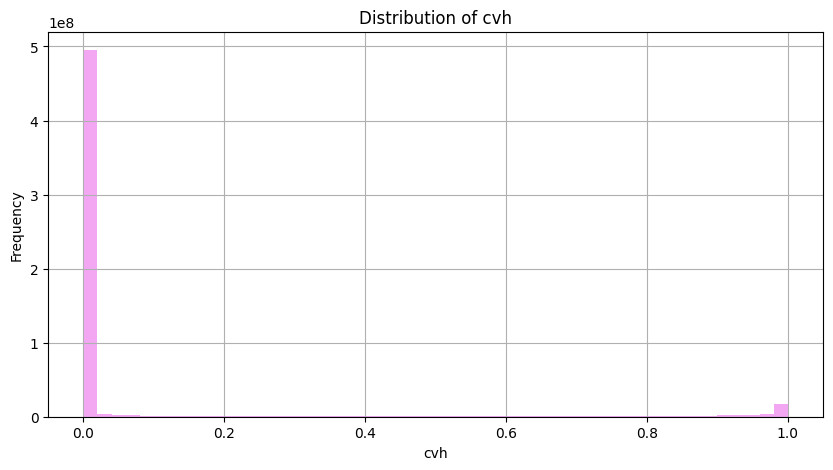

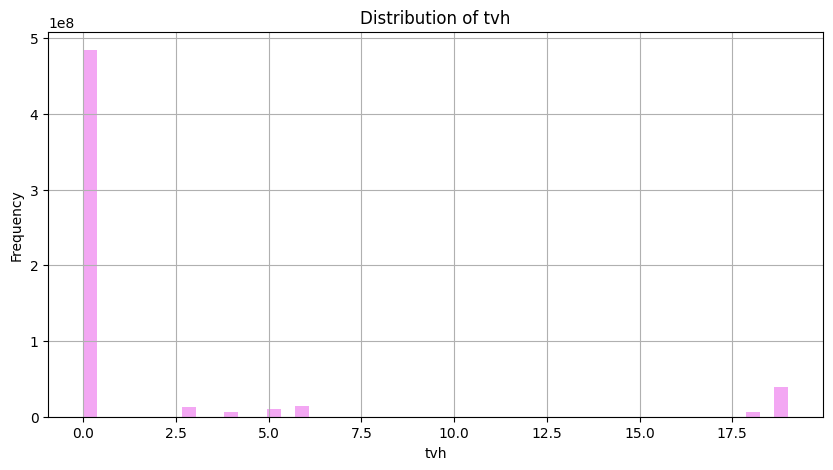

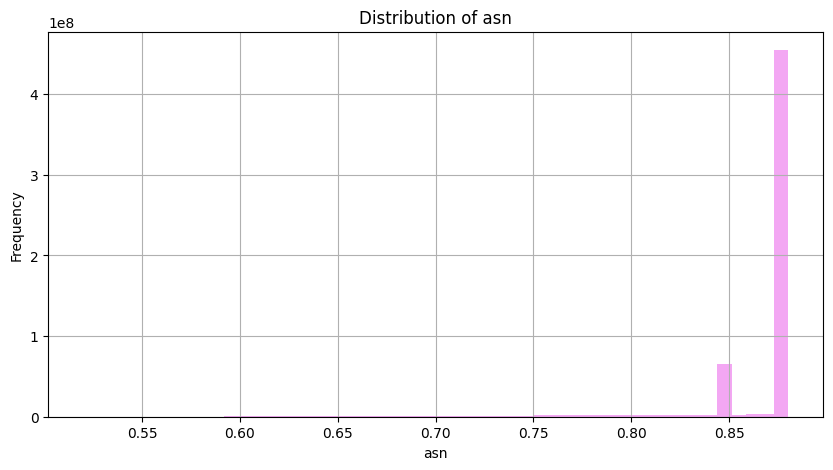

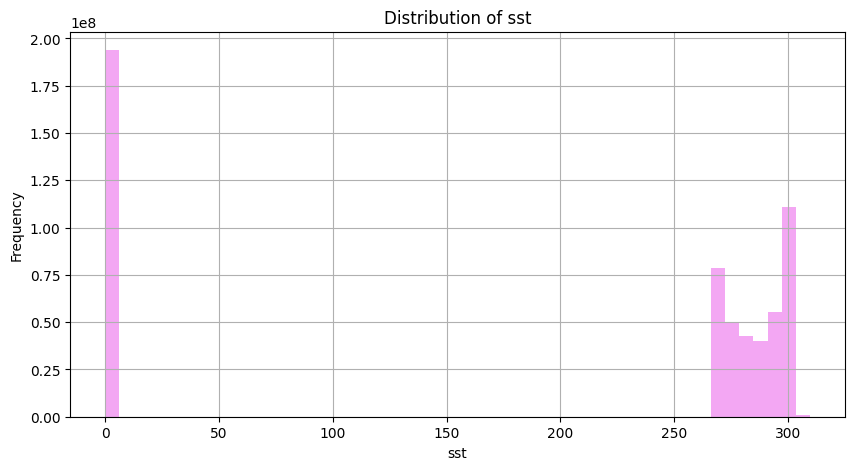

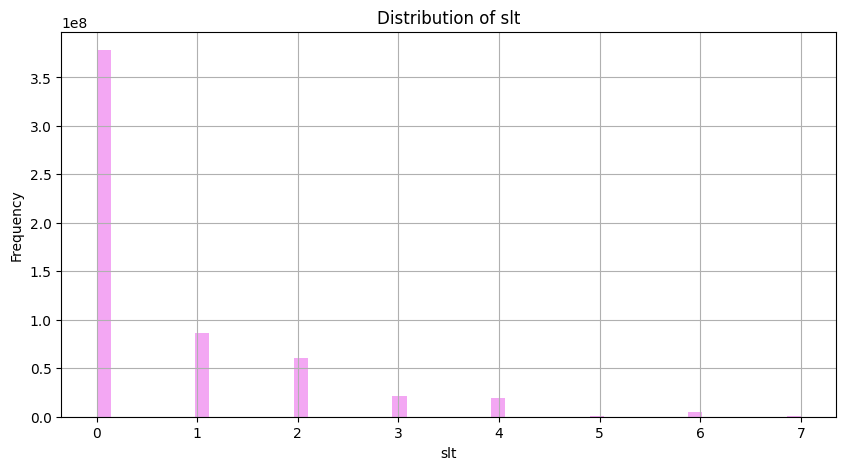

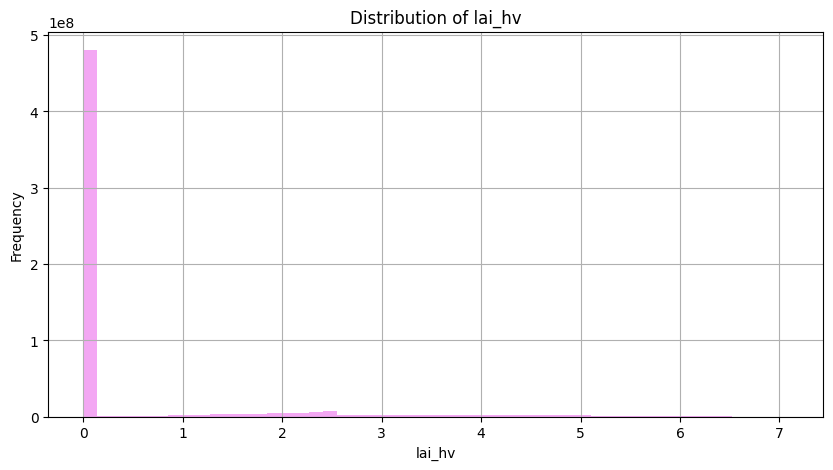

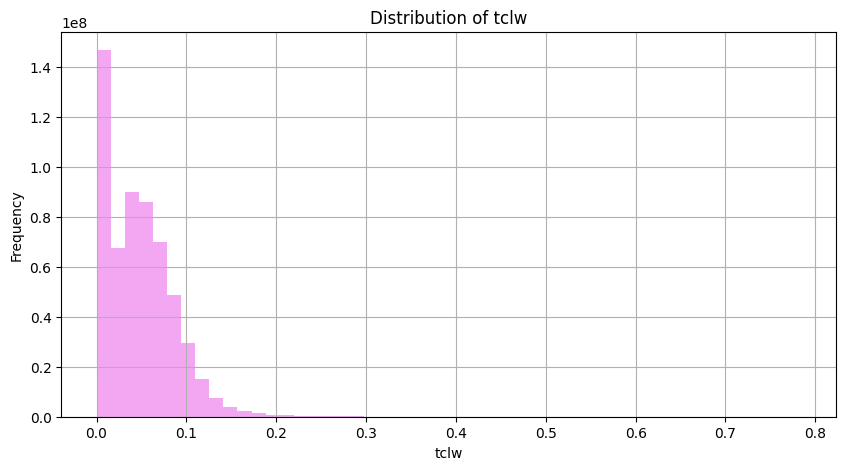

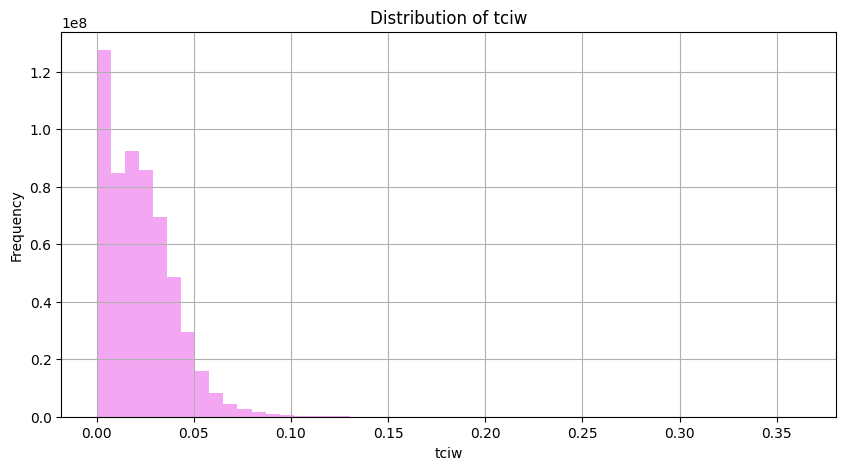

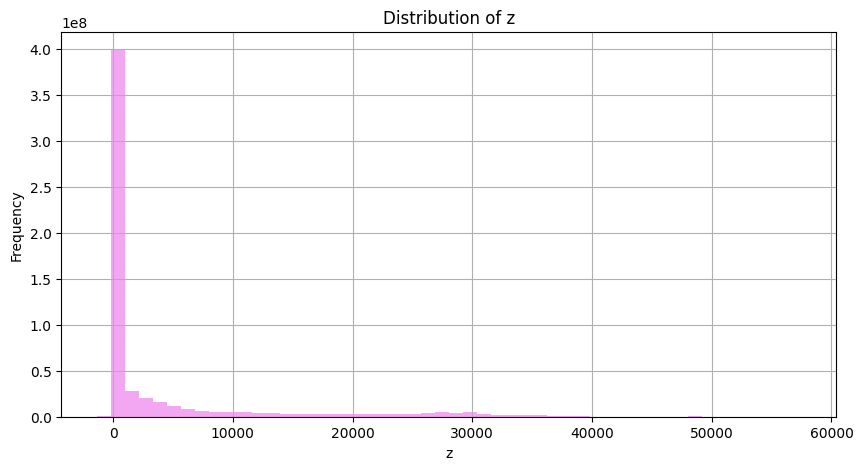

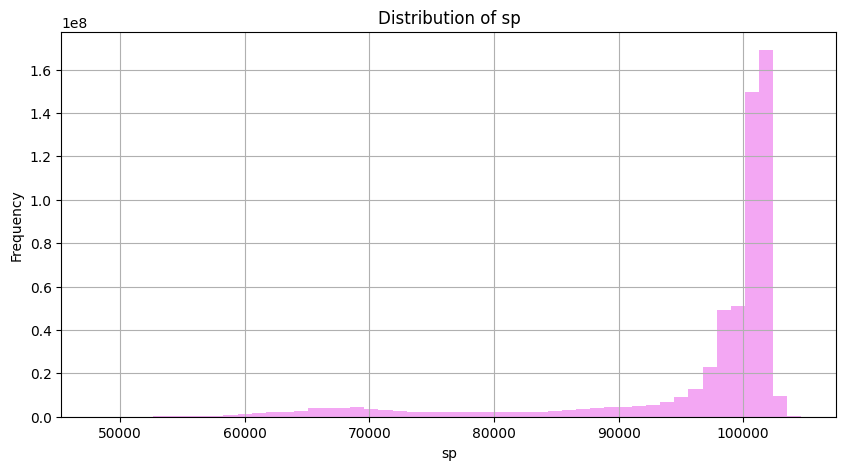

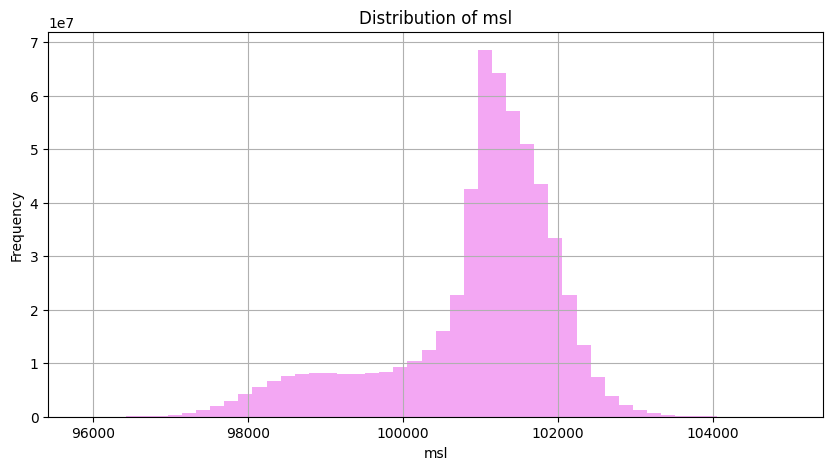

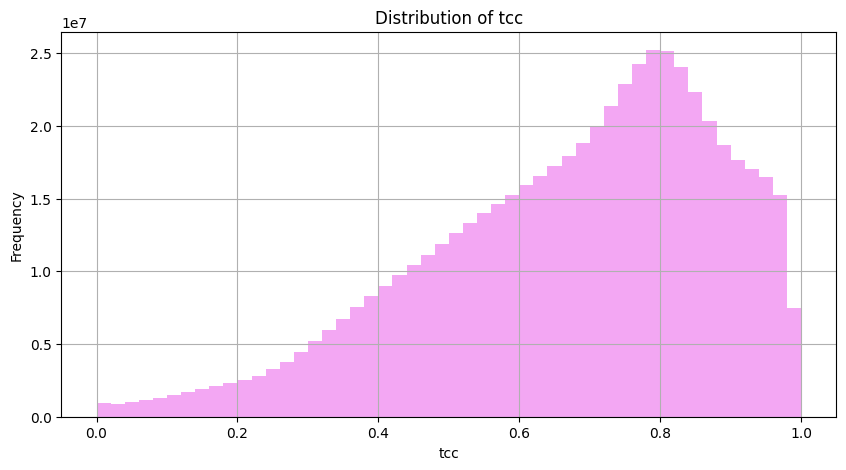

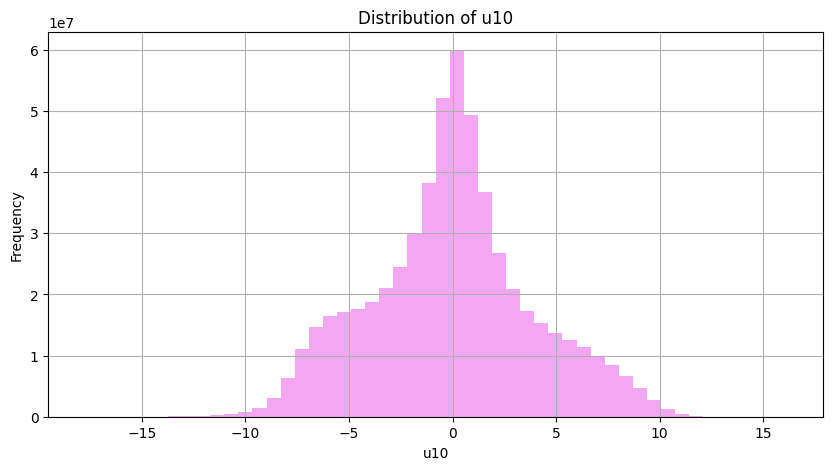

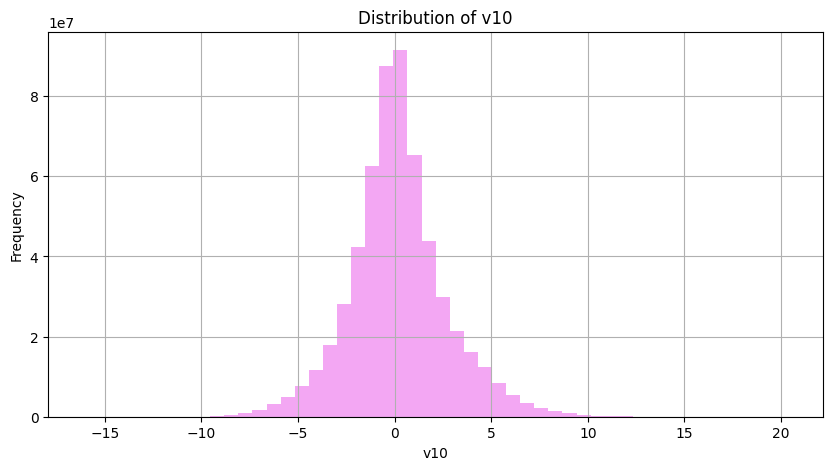

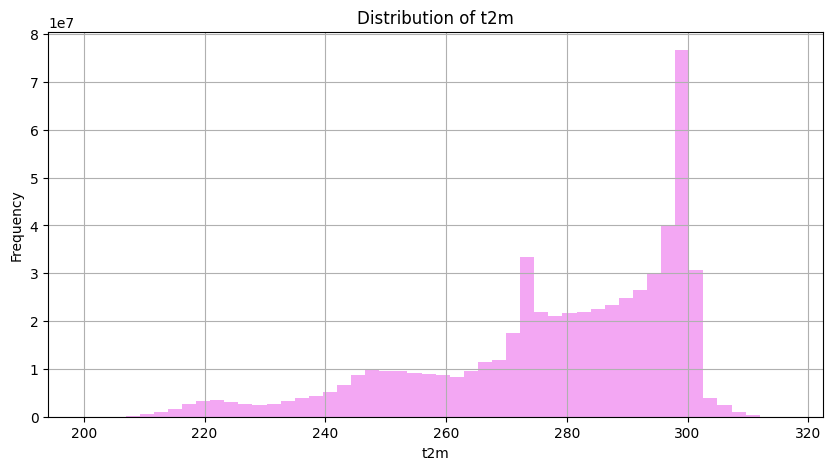

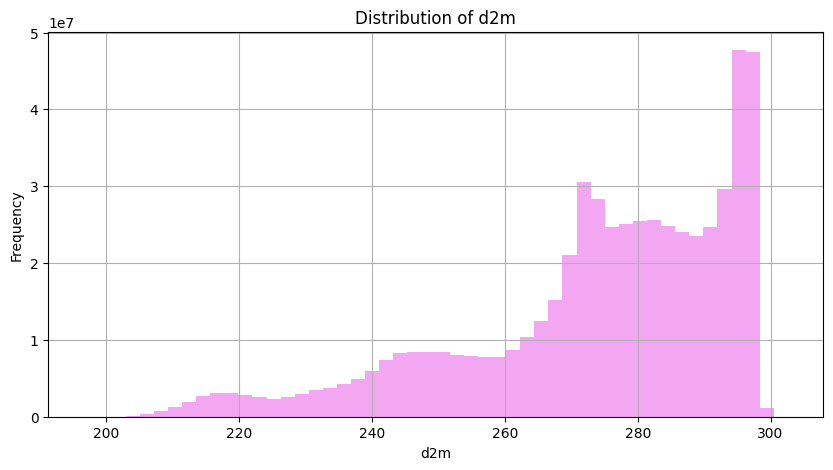

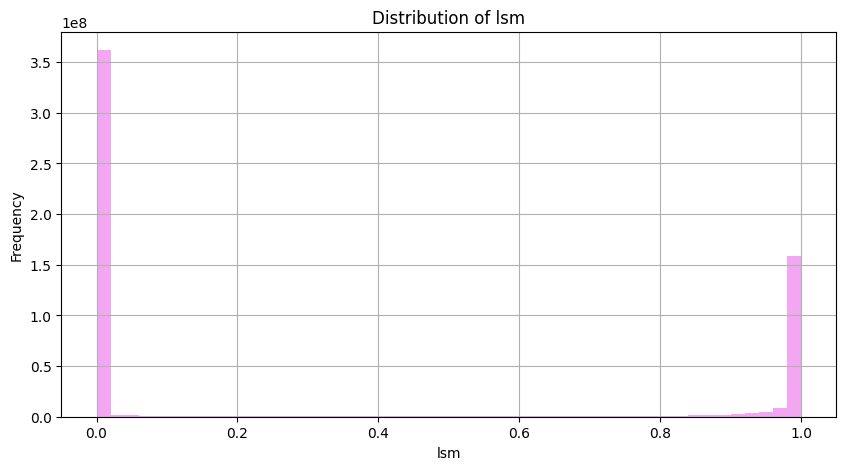

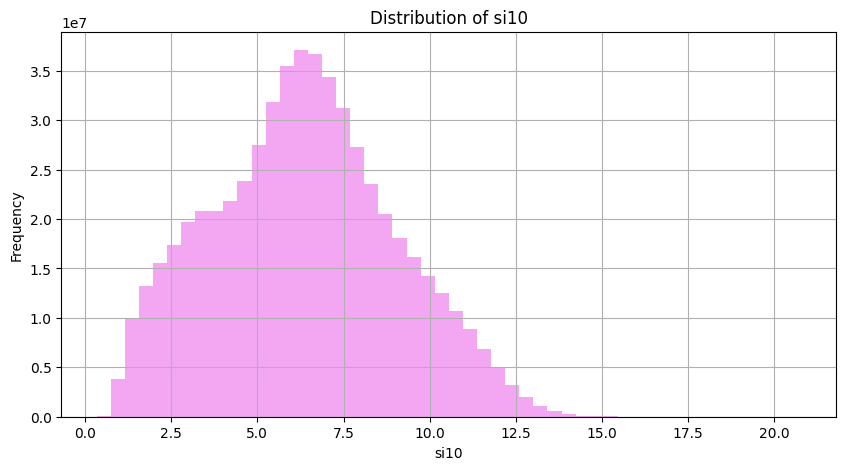

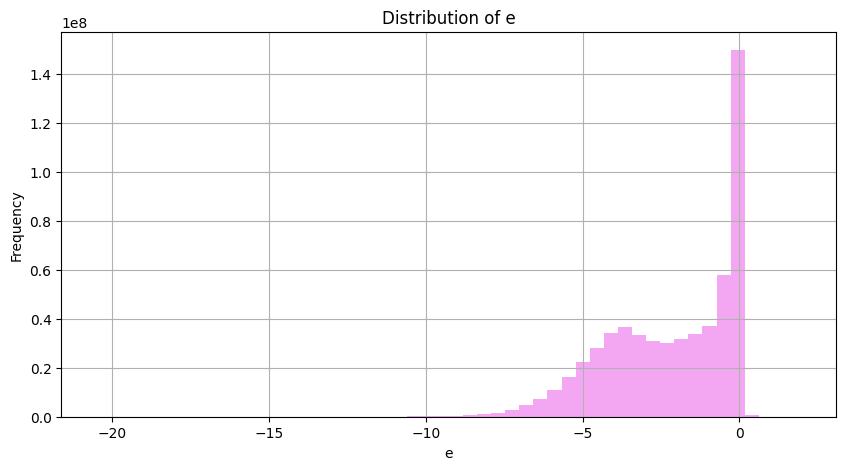

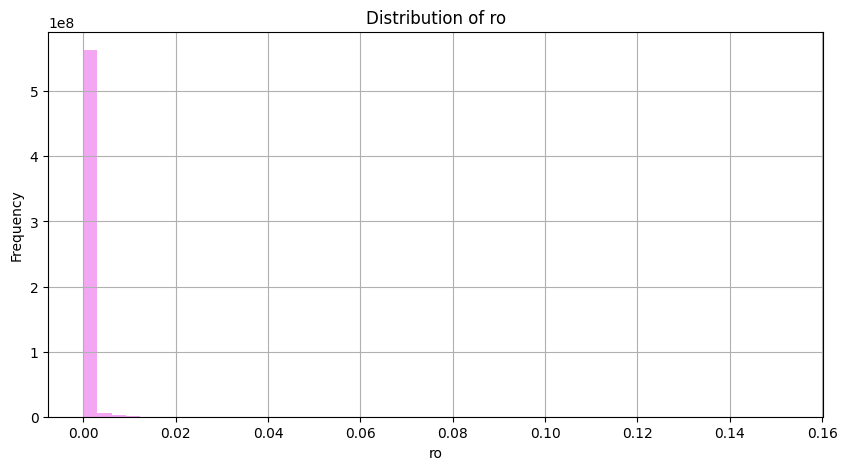

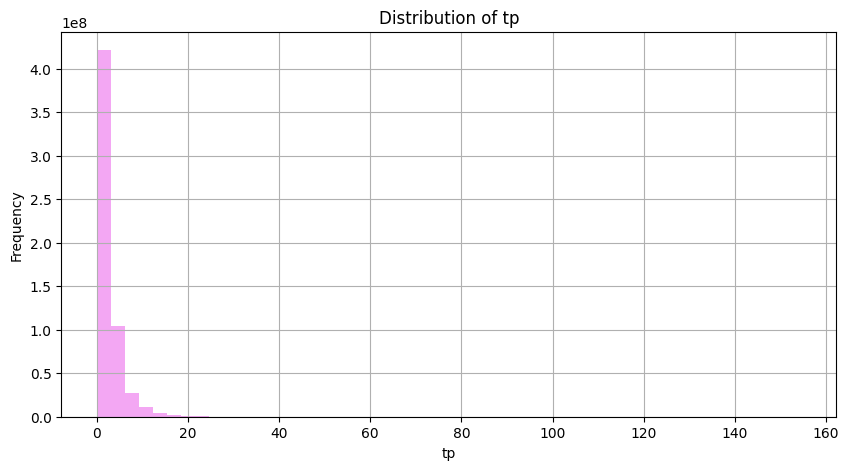

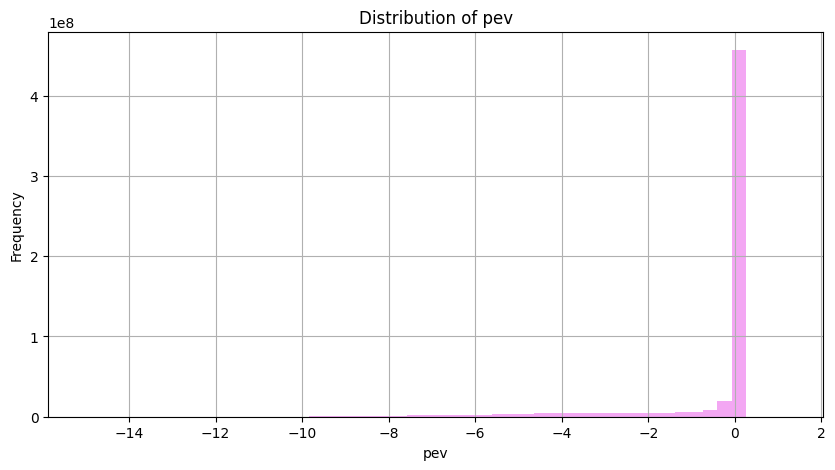

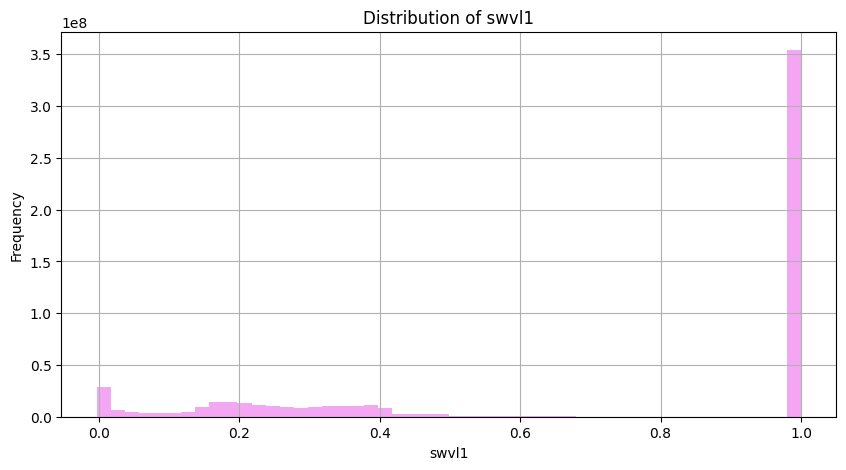

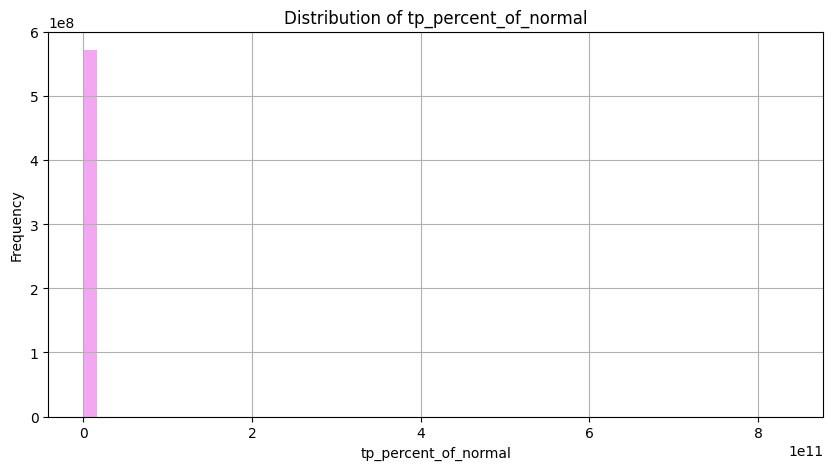

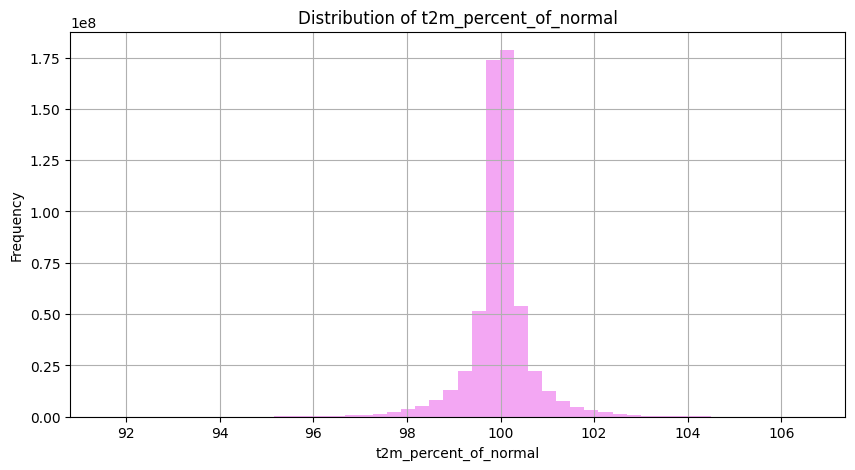

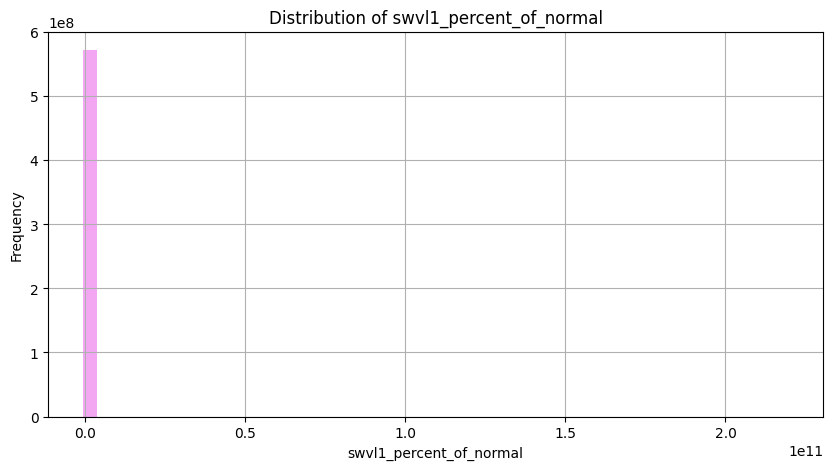

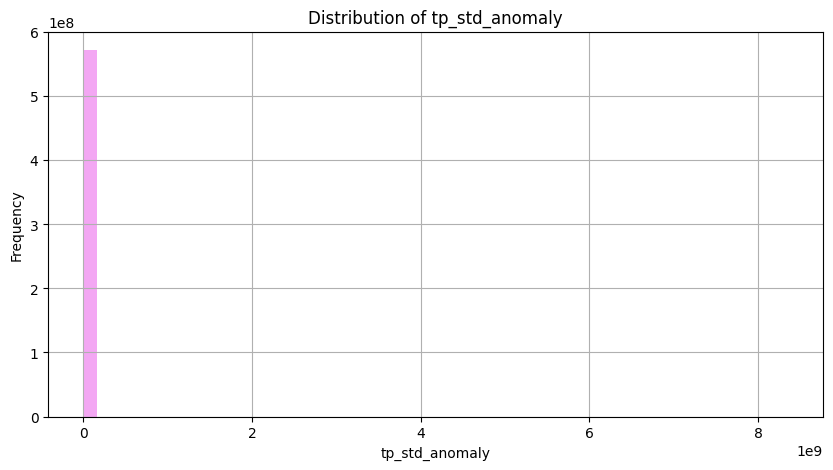

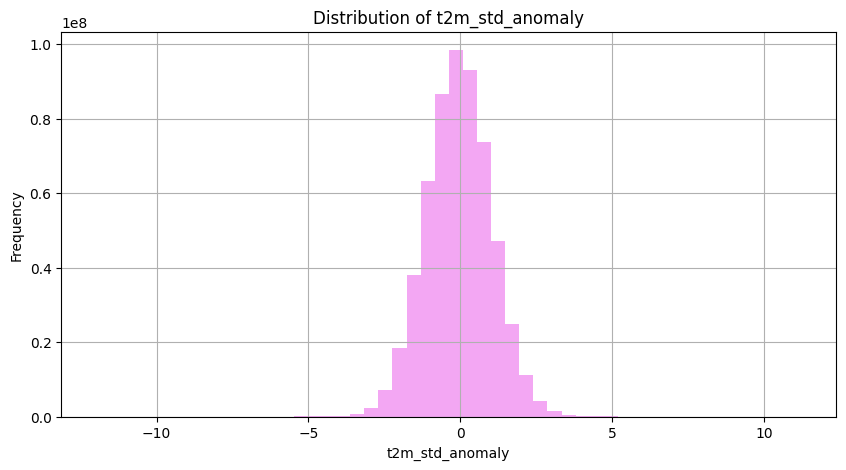

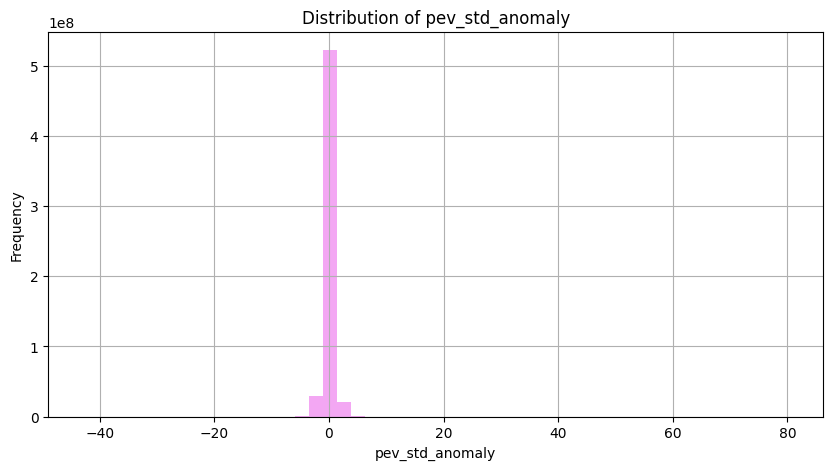

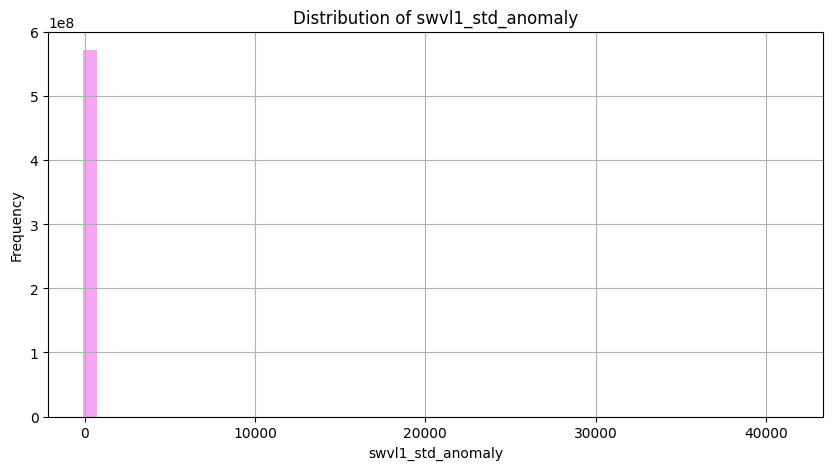

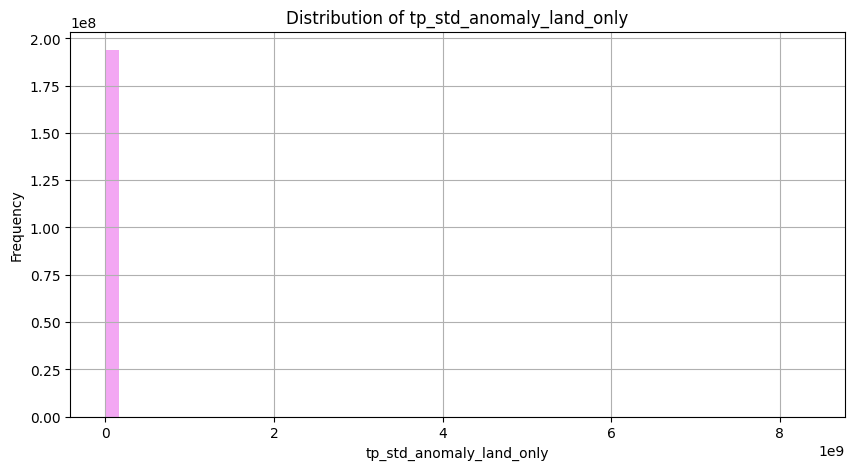

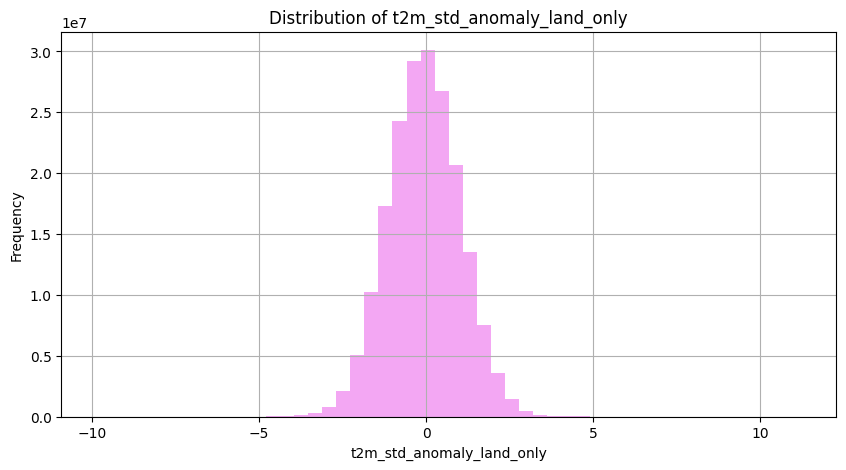

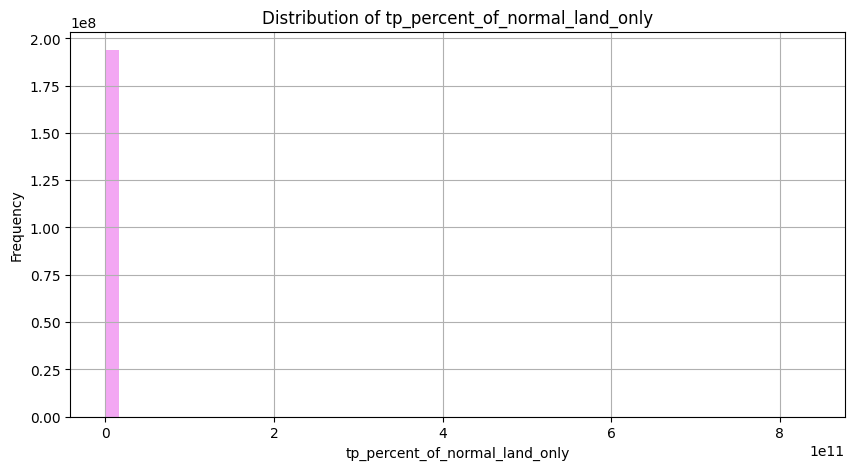

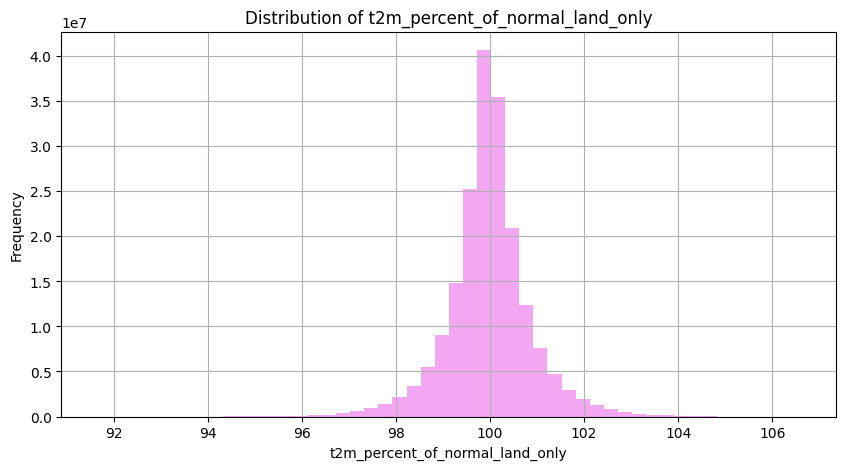

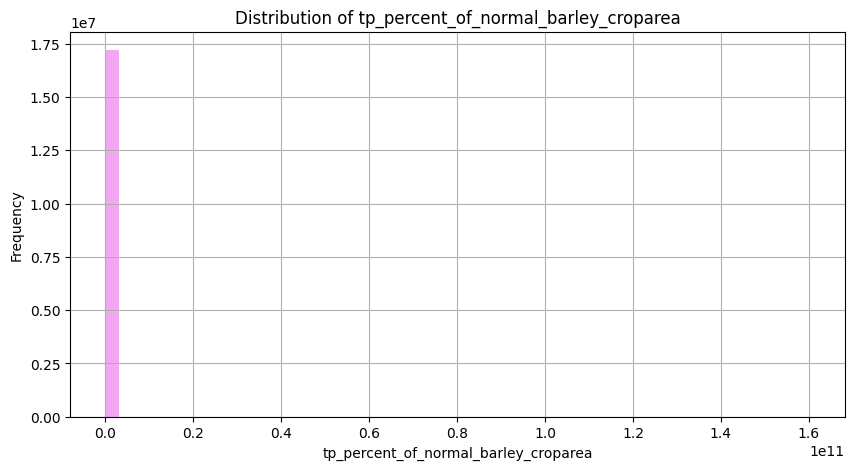

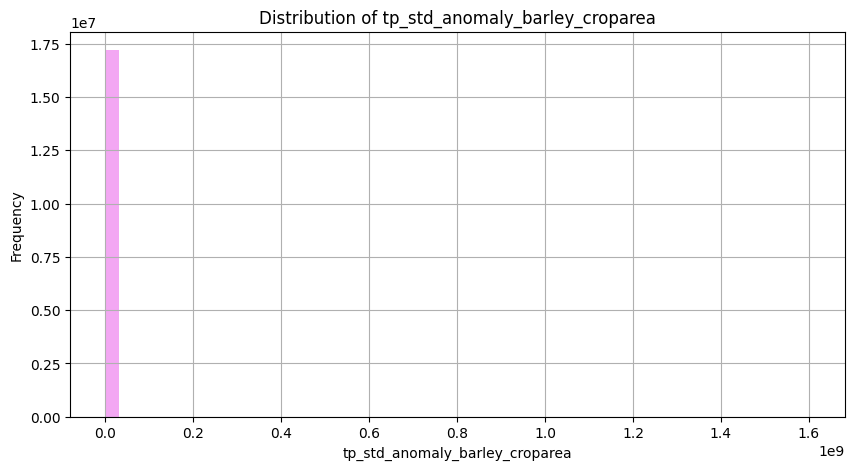

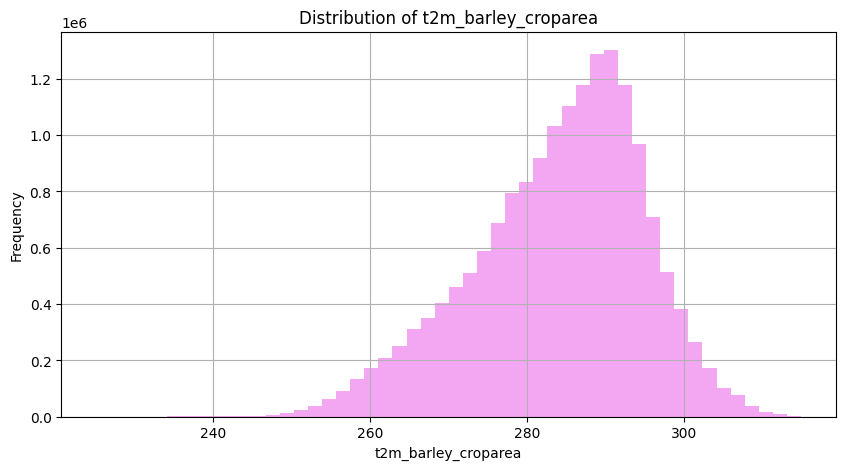

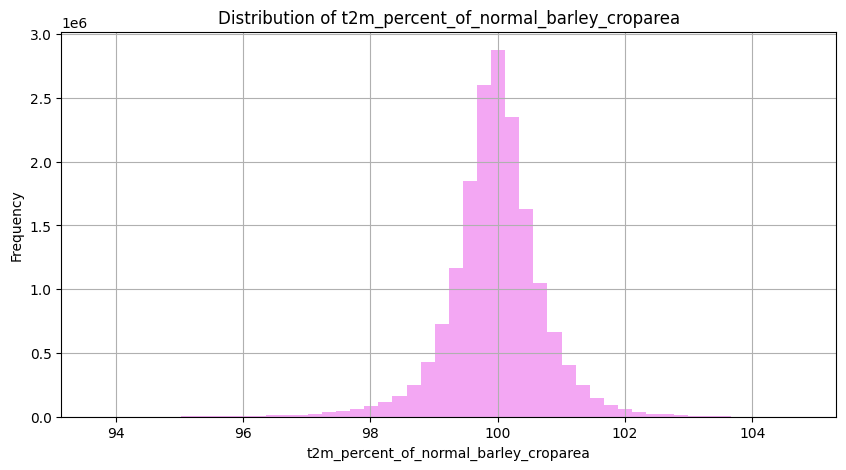

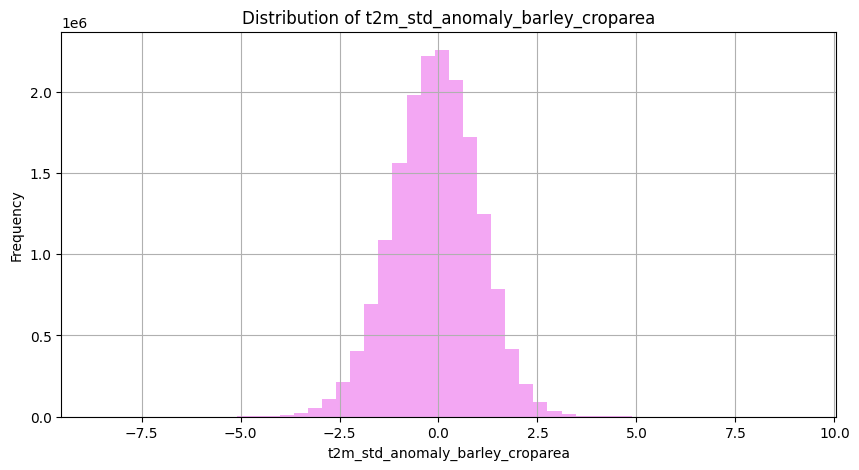

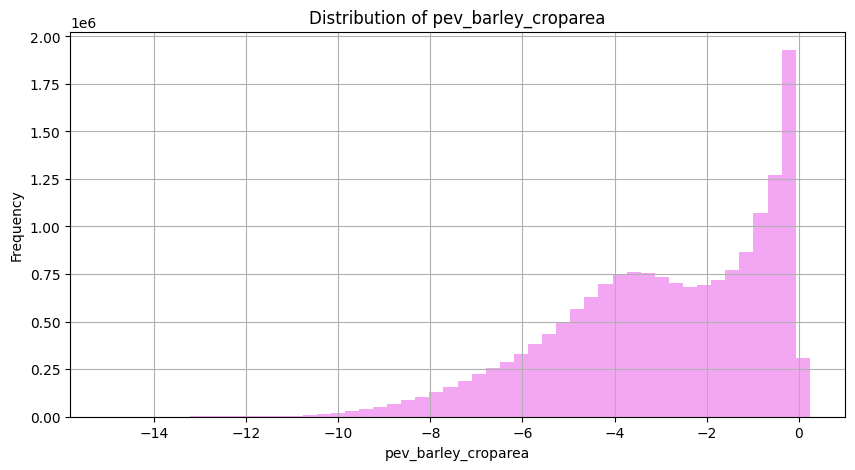

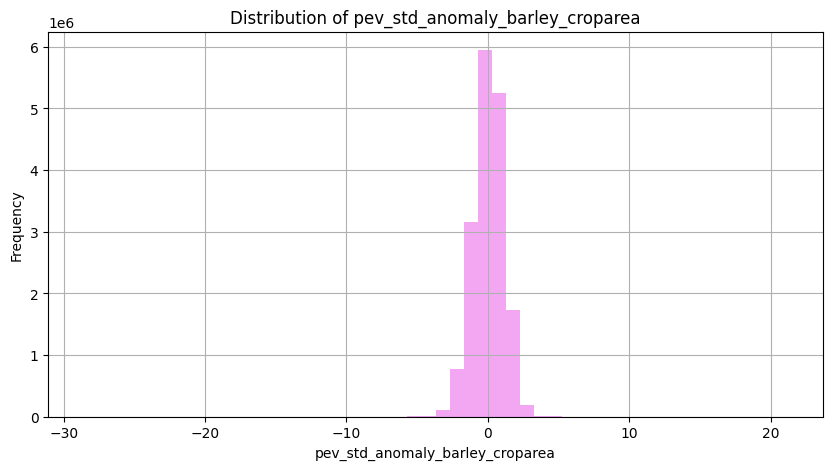

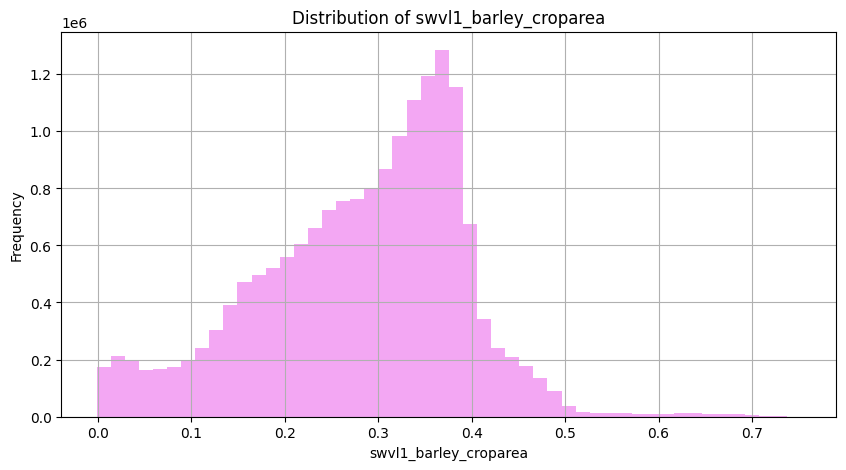

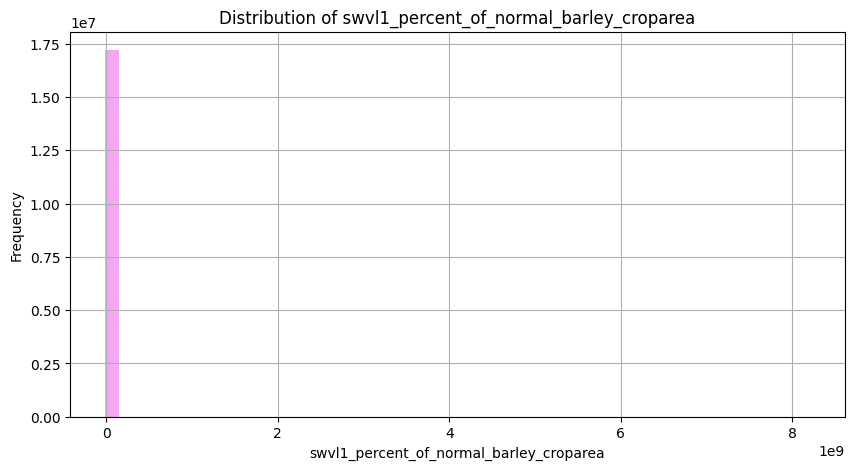

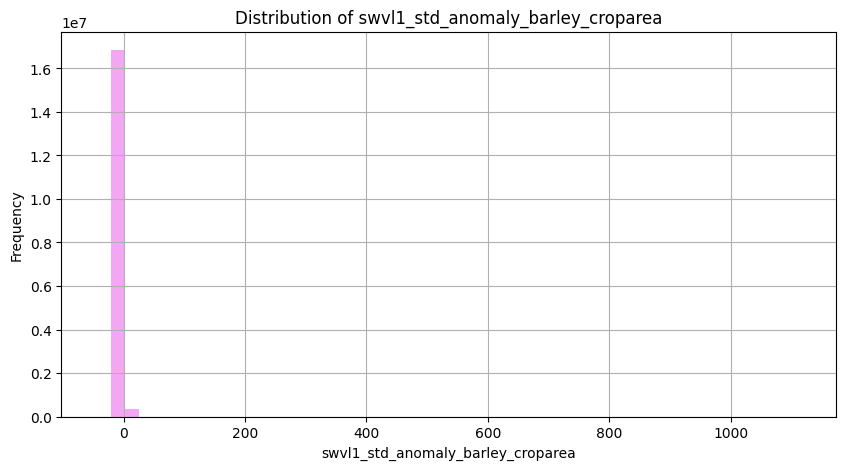

In [118]:
# To plot all variables
plot_variable_distributions(ds)

## Descriptive statistics

### Summmary statistics

In [120]:
ds

<xarray.Dataset> Size: 103GB
Dimensions:                                  (valid_time: 551, latitude: 721,
                                              longitude: 1440)
Coordinates:
    number                                   int64 8B 0
  * valid_time                               (valid_time) datetime64[ns] 4kB ...
  * latitude                                 (latitude) float64 6kB 90.0 ... ...
  * longitude                                (longitude) float64 12kB 0.0 ......
    expver                                   (valid_time) <U4 9kB dask.array<chunksize=(45,), meta=np.ndarray>
    month                                    (valid_time) int64 4kB 1 2 ... 11
    lat                                      (latitude) float64 6kB 90.0 ... ...
    lon                                      (longitude) float64 12kB 0.0 ......
Data variables: (12/45)
    cl                                       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    cvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    tvh                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    asn                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    sst                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    slt                                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    ...                                       ...
    t2m_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_barley_croparea                      (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    pev_std_anomaly_barley_croparea          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_barley_croparea                    (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_percent_of_normal_barley_croparea  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
    swvl1_std_anomaly_barley_croparea        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(45, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [121]:
import xarray as xr
import pandas as pd
import numpy as np

def generate_summary_statistics(ds: xr.Dataset, variable_name: str = None) -> pd.DataFrame:
    """
    Generates summary statistics for a specific variable or all variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
        variable_name (str, optional): The name of the variable for which to compute statistics.
                                       If None, statistics for all variables will be computed.

    Returns:
        pd.DataFrame: A DataFrame with summary statistics for the selected variable or all variables, 
                      including mean, median, min, max, std, and NaN count.
    
    Example:
        summary_df = generate_summary_statistics(ds)
        summary_df_single = generate_summary_statistics(ds, variable_name="temperature")
    """
    # Initialize an empty dictionary to store summary statistics
    stats = {
        "Variable": [],
        "Mean": [],
        "Median": [],
        "Min": [],
        "Max": [],
        "Std": [],
        "NaN Count": []
    }

    # Helper function to calculate statistics for a single variable
    def calculate_stats(var_name, var_data):
        flat_data = var_data.values.flatten()
        stats["Variable"].append(var_name)
        stats["Mean"].append(float(var_data.mean().values))
        stats["Median"].append(float(np.nanmedian(flat_data)))
        stats["Min"].append(float(var_data.min().values))
        stats["Max"].append(float(var_data.max().values))
        stats["Std"].append(float(var_data.std().values))
        stats["NaN Count"].append(int(np.isnan(flat_data).sum()))

    if variable_name:
        # Validate that the variable exists in the dataset
        if variable_name not in ds.data_vars:
            raise ValueError(f"Variable '{variable_name}' not found in the dataset.")
        calculate_stats(variable_name, ds[variable_name])
    else:
        # Calculate statistics for all variables
        for var_name, var_data in ds.data_vars.items():
            calculate_stats(var_name, var_data)

    # Convert the dictionary to a DataFrame for readability
    summary_df = pd.DataFrame(stats)
    
    return summary_df


In [124]:
summary_stats = generate_summary_statistics(ds)

KeyboardInterrupt: 

In [ ]:
summary_stats

# Correlations

In [122]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_correlation_heatmap(ds: xr.Dataset) -> None:
    """
    Generates a heatmap of correlations between variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
    
    Example:
        plot_variable_correlation_heatmap(ds)
    """
    
    # Aggregate data by taking the mean over spatial dimensions for each variable
    data_dict = {}
    for var_name, var_data in ds.data_vars.items():
        # Compute the mean across latitude and longitude to get a 1D time series
        time_series = var_data.mean(dim=["latitude", "longitude"], skipna=True)
        data_dict[var_name] = time_series.values

    # Convert to DataFrame for correlation calculation
    df = pd.DataFrame(data_dict, index=ds.valid_time.values)
    
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap of the correlation matrix with enhanced readability
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Correlation Heatmap of Dataset Variables", fontsize=14)
    plt.show()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



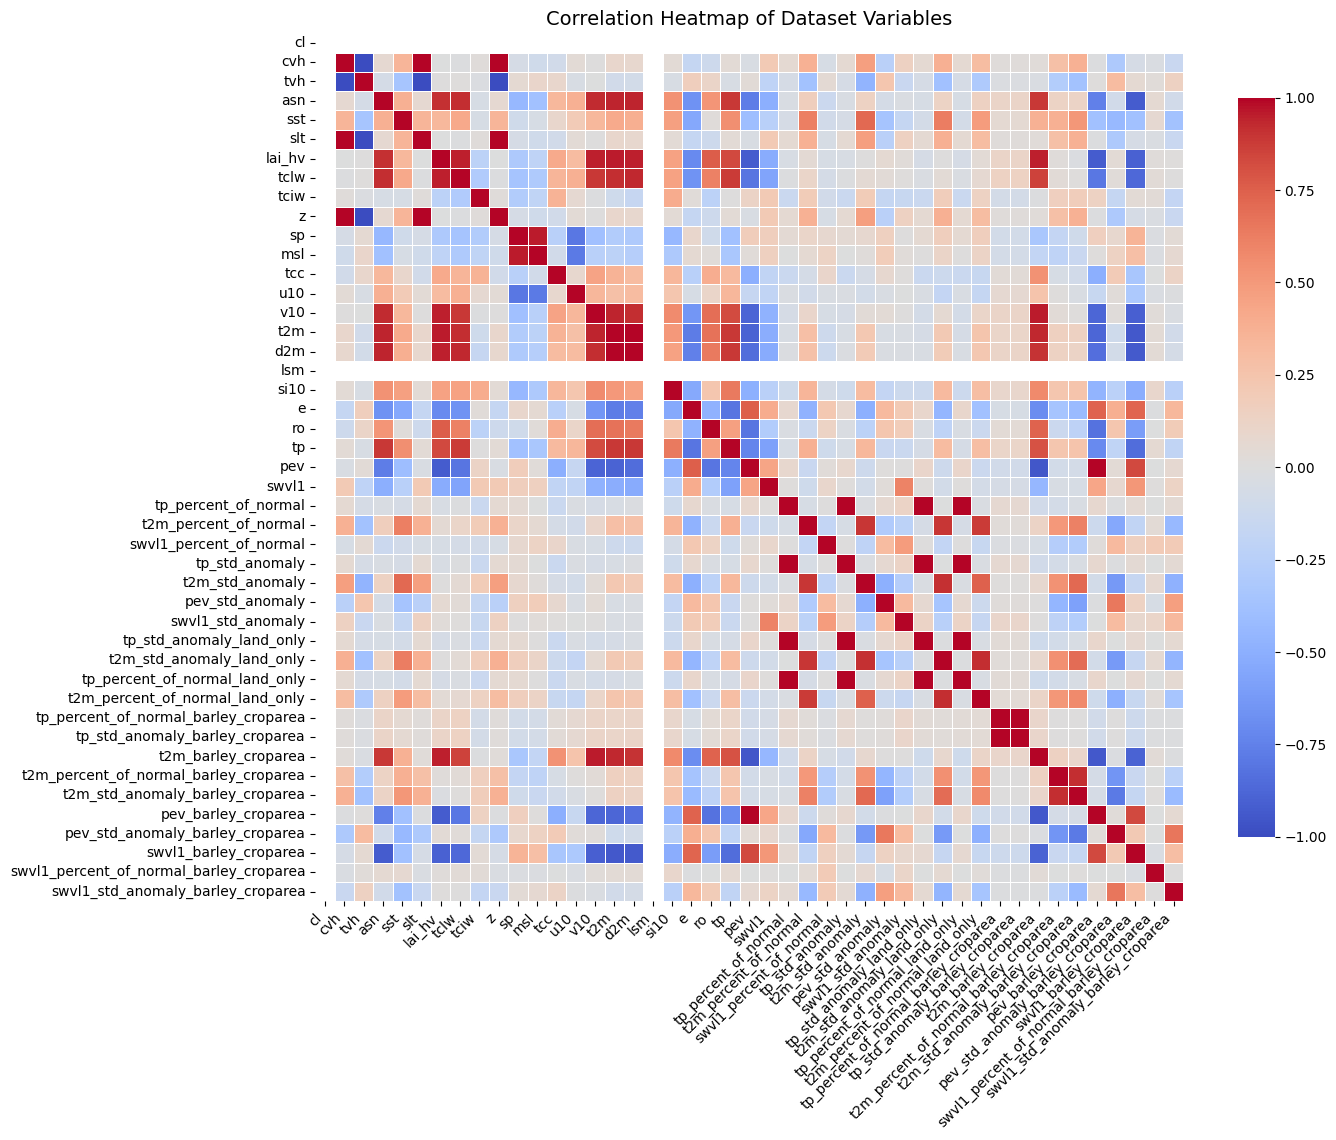

In [123]:
plot_variable_correlation_heatmap(ds)